In [1]:
# Import libraries and set desired options
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

### 1. Data Downloading and Transformation
Register on [Kaggle](www.kaggle.com), if you have not done it before.
Go to the competition [page](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) and download the data.

In [2]:
# Read the training and test data sets, change paths if needed
times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv('../../../data/train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv('../../../data/test_sessions.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [3]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open(r"../../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), 
                          columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


### 2. Brief Exploratory Data Analysis

In [4]:
# Top websites in the training data set
top_sites = pd.Series(train_df[sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(top_sites)
sites_dict.loc[top_sites.drop(0).index]

21     123776
0      122730
23      87619
782     77055
22      58258
dtype: int64


,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com


In [5]:
# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# Find sessions' starting and ending
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


*We are using the notion of "approximately the same". To be strict, let's define it: $a$ is approximately the same as $b$ ($a \approx b $) if their difference is less than or equal to 5% of the maximum between $a$ and $b$, i.e. $a \approx b \leftrightarrow \frac{|a-b|}{max(a,b)} \leq 0.05$.*

In [6]:
def approximately_the_same(a, b):
    # protect against divide by zero
    if a == b == 0: return True
    return (abs(a - b) / max(a, b)) <= 0.05

### Create united dataframe of the initial data

In [33]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data
# Ensure it does not have 'target' because we don't want to train on data with the correct answer
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [8]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [9]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [10]:
full_sites_sparse.shape

(336358, 48371)

## Training the Model

In [11]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [12]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9195239548763581
CPU times: user 15.8 s, sys: 68.6 ms, total: 15.9 s
Wall time: 2.77 s


The first model demonstrated the quality of 0.92 on the validation set. Let's take it as the first baseline and starting point.

In [13]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [14]:
# Train the model on the whole training data set
# Use random_state=17 for repeatability
# Parameter C=1 by default, but here we set it explicitly
lr = LogisticRegression(C=1.0, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for test data set
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'submissions/baseline_1.csv')

### Add additional features

In [15]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)



In [16]:
# Add start_month feature
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')

In [17]:
# Add the new feature to the sparse matrix
tmp = full_new_feat[['start_month']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.7508354860175162


The quality of the model has decreased significantly. We should scale the new feature.

In [18]:
# Add the new standardized feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9196984641972088


### Add start_hour as a feature

In [19]:
full_new_feat['start_hour'] = full_df['time1'].apply(lambda ts: ts.hour).astype(np.float64)

### Add morning as a feature

In [20]:
def is_morning(x):
    if x <= 11:
        return 1.0
    else:
        return 0.0
    
full_new_feat['morning'] = full_new_feat['start_hour'].apply(is_morning)

In [21]:
full_new_feat.head()

,start_month,start_hour,morning
session_id,,,
21669,201301.0,8.0,1.0
54843,201301.0,8.0,1.0
77292,201301.0,8.0,1.0
114021,201301.0,8.0,1.0
146670,201301.0,8.0,1.0


### Train with new features

In [22]:
# Add start_hour, no scaling
tmp1 = full_new_feat[['start_hour']].values
tmp2 = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp1[:idx_split,:], tmp2[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9572954104652455


In [23]:
# Add start_hour, with scaling
tmp1 = StandardScaler().fit_transform(full_new_feat[['start_hour']])
tmp2 = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp1[:idx_split,:], tmp2[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9579238553637766


In [24]:
# Add morning, no scaling
tmp1 = full_new_feat[['morning']].values
tmp2 = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp1[:idx_split,:], tmp2[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9486674643372993


In [25]:
# Add morning, with scaling
tmp1 = StandardScaler().fit_transform(full_new_feat[['morning']])
tmp2 = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp1[:idx_split,:], tmp2[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9487791744561831


## Regularization and Parameter Tuning

We have introduced features that improve the quality of our model in comparison with the first baseline. Can we do even better? After we have changed the training and test sets, it almost always makes sense to search for the optimal hyperparameters - the parameters of the model that do not change during training.

In the logistic regression that we use, the weights of each feature are changing, and we find their optimal values during training; meanwhile, the regularization parameter remains constant. This is the hyperparameter that we are going to optimize now.

Calculate the quality on a validation set with a regularization parameter, which is equal to 1 by default:

In [26]:
# Compose the training set
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 
                                                           'start_hour', 
                                                           'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))

# Capture the quality with default parameters
score_C_1 = get_auc_lr_valid(X_train, y_train)
print(score_C_1)

0.959152062833017


We will try to beat this result by optimizing the regularization parameter. We will take a list of possible values of C and calculate the quality metric on the validation set for each of C-values:

In [27]:
from tqdm import tqdm

# List of possible C-values
Cs = np.logspace(-3, 1, 10)
scores = []
for C in tqdm(Cs):
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))

100%|██████████| 10/10 [00:21<00:00,  4.07s/it]


Plot the graph of the quality metric (AUC-ROC) versus the value of the regularization parameter. The value of quality metric corresponding to the default value of C=1 is represented by a horizontal dotted line:

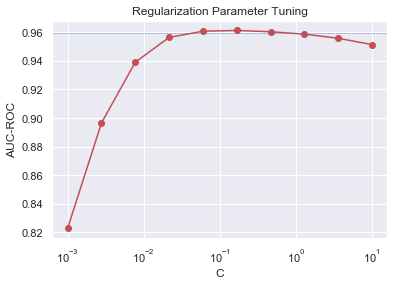

In [28]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Regularization Parameter Tuning')
# horizontal line -- model quality with default C value
plt.axhline(y=score_C_1, linewidth=.5, color='b', linestyle='dashed') 
plt.show()

In [29]:
score_mappings = list(zip(scores, Cs))
score_mappings

[(0.8229644453864324, 0.001),
 (0.8965353710466695, 0.0027825594022071257),
 (0.9390416751204054, 0.007742636826811269),
 (0.9563605175378849, 0.021544346900318832),
 (0.9606926057562715, 0.05994842503189409),
 (0.9612125106879411, 0.1668100537200059),
 (0.9603241133235753, 0.46415888336127775),
 (0.9586711054833366, 1.2915496650148828),
 (0.9557601511286948, 3.593813663804626),
 (0.9513231459743297, 10.0)]

In [30]:
max(node[0] for node in score_mappings)

0.9612125106879411

Use the C value with the highest score

In [31]:
get_auc_lr_valid(X_train, y_train, C=0.1668100537200059)

0.9612125106879411

In [32]:
C_value = 0.1668100537200059

# Prepare the training and test data
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 
                                                           'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=C_value, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for the test set
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'submissions/01-a1-baseline_2.csv')